In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [9]:
df = pd.read_csv('C:/Users/Tony/Desktop/orginal_year.csv', names=['year','value'])
df

,year,value
0,1750,7.143083
1,1751,7.037500
2,1752,7.644636
3,1753,7.384500
4,1754,7.949417
...,...,...
268,2018,9.726167
269,2019,9.923750
270,2020,10.080833
271,2021,9.827250


In [10]:
y = df['value'].values.astype(float)
test_size = 12
# 划分训练和测试集，最后12个值作为测试集
train_set = y[:-test_size]
test_set = y[-test_size:]

In [13]:
from sklearn.preprocessing import MinMaxScaler
# 归一化处理
scaler = MinMaxScaler(feature_range=(-1, 1))
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [17]:
# 转换成 tensor
train_norm = torch.FloatTensor(train_norm).view(-1)
window_size = 12
#将数据按window_size一组分段，每次输入一段后，会输出一个预测的值y_pred
#y_pred与每段之后的window_size+1个数据作为对比值，用于计算损失函数
#例如前5个数据为(1,2,3,4,5),取前4个进行CNN预测,得出的值与(5)比较计算loss
#这里使用每组13个数据,最后一个数据作评估值,即window_size=12
def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window, label))
    return out
train_data = input_data(train_norm,window_size)
# 打印一组数据集
train_data[0]

(tensor([-0.4076, -0.4653, -0.1336, -0.2757,  0.0328, -0.0991,  0.0649,  0.1123,
         -0.9941, -0.5063, -1.0000, -0.1630]),
 tensor([-0.1934]))

In [21]:
class CNNnetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1d = nn.Conv1d(1,64,kernel_size=2)
        self.relu = nn.ReLU(inplace=True)
        self.Linear1= nn.Linear(64*11,50)
        self.Linear2= nn.Linear(50,1)      
    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)
        return x

In [23]:
import time
torch.manual_seed(101)
model =CNNnetwork()
# 设置损失函数,这里使用的是均方误差损失
criterion = nn.MSELoss()
# 设置优化函数和学习率lr
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
# 设置训练周期
epochs = 100
model.train()
start_time = time.time()
for epoch in range(epochs):
    for seq, y_train in train_data:
        # 每次更新参数前都梯度归零和初始化
        optimizer.zero_grad()
        # 注意这里要对样本进行reshape，
        # 转换成conv1d的input size（batch size, channel, series length）
        y_pred = model(seq.reshape(1,1,-1))
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')  
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.66804302
Epoch:  2 Loss: 0.54501343
Epoch:  3 Loss: 0.45355064
Epoch:  4 Loss: 0.39104727
Epoch:  5 Loss: 0.32226747
Epoch:  6 Loss: 0.02267911
Epoch:  7 Loss: 0.00175701
Epoch:  8 Loss: 0.00036171
Epoch:  9 Loss: 0.00015221
Epoch: 10 Loss: 0.00004723
Epoch: 11 Loss: 0.00001815
Epoch: 12 Loss: 0.00004576
Epoch: 13 Loss: 0.00004888
Epoch: 14 Loss: 0.00008522
Epoch: 15 Loss: 0.00020709
Epoch: 16 Loss: 0.00051854
Epoch: 17 Loss: 0.00051438
Epoch: 18 Loss: 0.00009246
Epoch: 19 Loss: 0.00083267
Epoch: 20 Loss: 0.00121040
Epoch: 21 Loss: 0.00108738
Epoch: 22 Loss: 0.00092492
Epoch: 23 Loss: 0.00115218
Epoch: 24 Loss: 0.00068852
Epoch: 25 Loss: 0.00090090
Epoch: 26 Loss: 0.00079793
Epoch: 27 Loss: 0.00097771
Epoch: 28 Loss: 0.00086881
Epoch: 29 Loss: 0.00092184
Epoch: 30 Loss: 0.00315905
Epoch: 31 Loss: 0.00000015
Epoch: 32 Loss: 0.00004176
Epoch: 33 Loss: 0.00002608
Epoch: 34 Loss: 0.00167037
Epoch: 35 Loss: 0.00095853
Epoch: 36 Loss: 0.00070605
Epoch: 37 Loss: 0.00000031
E

[0.7532718777656555,
 0.7087060213088989,
 0.8225105404853821,
 0.9142824411392212,
 0.8834186792373657,
 0.7779446840286255,
 0.9851143956184387,
 0.8898828029632568,
 1.0,
 0.8425856232643127,
 0.8911573886871338,
 0.986024796962738,
 1.0701777935028076,
 0.7780015468597412,
 0.9993435144424438,
 1.0009995698928833,
 1.1725465059280396,
 0.6458373069763184,
 1.1103098392486572,
 1.0992525815963745,
 1.4088581800460815,
 0.8265949487686157,
 1.624120831489563,
 1.277166724205017]

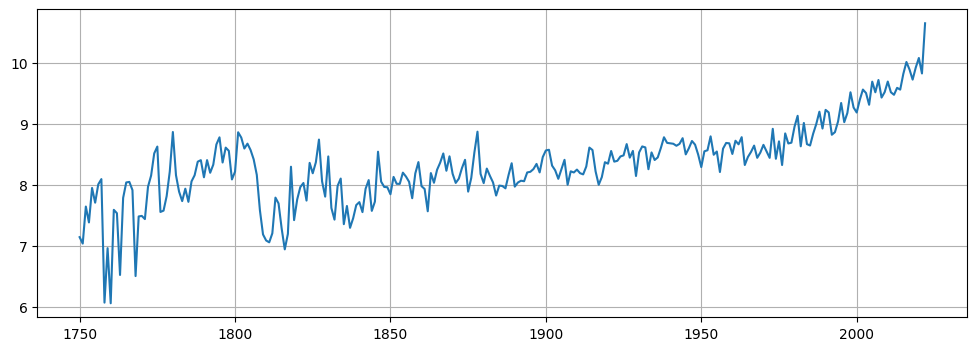

In [32]:
future = 12
# 选取序列最后12个值开始预测
preds = train_norm[-window_size:].tolist()
# 设置成eval模式
model.eval()
# 循环的每一步表示向时间序列向后滑动一格
for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        preds.append(model(seq.reshape(1,1,-1)).item())
# 逆归一化还原真实值
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
# 对比真实值和预测值
plt.figure(figsize=(12,4))
plt.grid(True)
plt.plot(df['year'],df['value'])
preds